# Semantic Segmentation Model for Water Body Classification

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

minmaxscaler = MinMaxScaler()

## Data Loading and Preprocessing

In [2]:
dataset_root_folder = r"C:\Users\RITESH KR. SHAW\Desktop\Water_body_classifier"
dataset_name = "Semantic segmentation dataset"
image_patch_size = 256
image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(len(image_dataset))
print(len(mask_dataset))

945
945


## Visualize Random Image and Mask

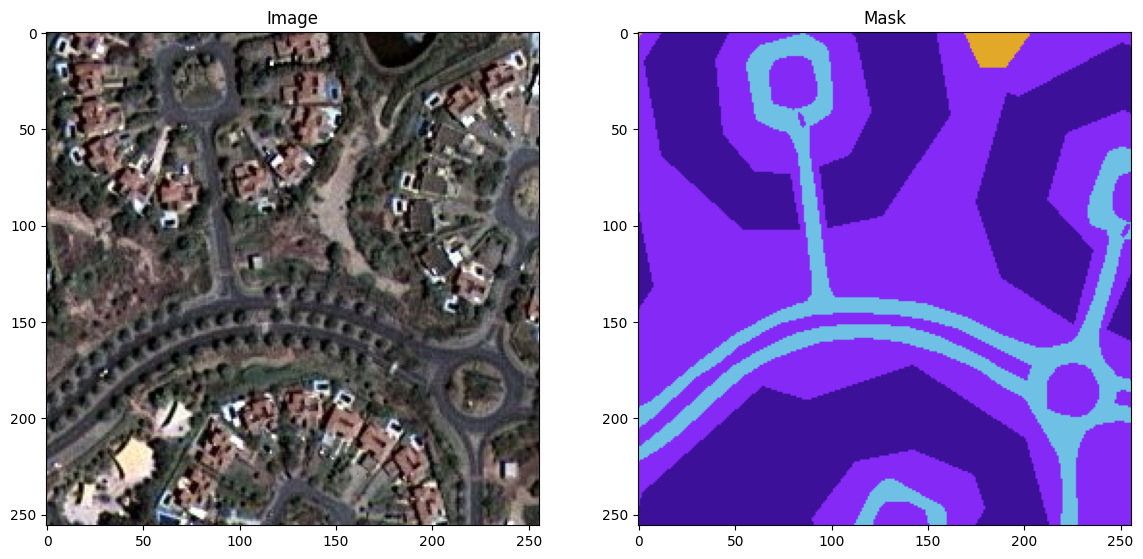

In [3]:
random_image_id = random.randint(0, len(image_dataset))
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.title('Mask')
plt.show()

## Define Class Colors

In [4]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0, 2, 4)))
print('Building:', class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0, 2, 4)))
print('Land:', class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0, 2, 4)))
print('Road:', class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation:', class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0, 2, 4)))
print('Water:', class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled:', class_unlabeled)

Building: [ 60  16 152]
Land: [132  41 246]
Road: [110 193 228]
Vegetation: [254 221  58]
Water: [226 169  41]
Unlabeled: [155 155 155]


## Convert RGB Masks to Labels

In [5]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:, :, 0]
    return label_segment

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
print('Unique labels:', np.unique(labels))

Unique labels: [0 1 2 3 4 5]


## Visualize Image and Corresponding Label

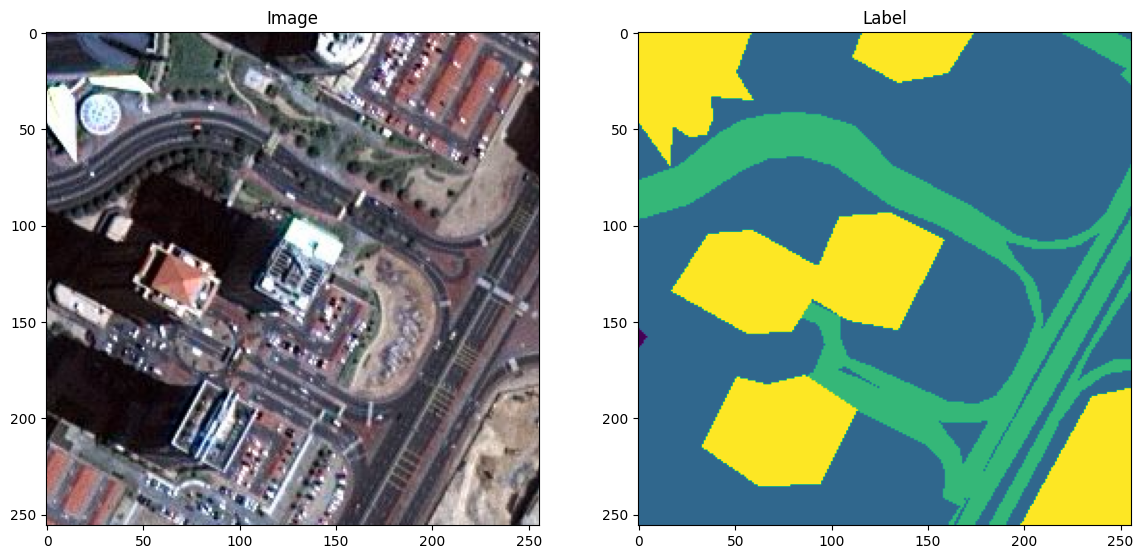

In [6]:
random_image_id = random.randint(0, len(image_dataset))
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.title('Image')
plt.subplot(122)
plt.imshow(labels[random_image_id][:, :, 0])
plt.title('Label')
plt.show()

## Prepare Data for Training

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

total_classes = len(np.unique(labels))
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
labels_categorical_dataset = labels_categorical_dataset.astype('float32')

master_training_dataset = image_dataset
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

## Define U-Net Model

In [8]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
import tensorflow as tf

def jaccard_coef(y_true, y_pred):
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))
    source_input = inputs

    c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1, 1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

Segmentation Models: using `tf.keras` framework.


## Compile and Train Model

In [9]:
metrics = ["accuracy", jaccard_coef]

def get_deep_learning_model():
    return multi_unet_model(n_classes=total_classes, image_height=image_height, image_width=image_width, image_channels=image_channels)

model = get_deep_learning_model()
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
model.summary()

model_history = model.fit(X_train, y_train,
                          batch_size=2,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,190 (7.41 MB)

 Trainable params: 1,941,190 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\RITESH KR. SHAW\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


402/402 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5924 - jaccard_coef: 0.3078 - loss: 0.9997

C:\Users\RITESH KR. SHAW\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(2, 256, 256, 3))
  warnings.warn(msg)


402/402 ━━━━━━━━━━━━━━━━━━━━ 136s 319ms/step - accuracy: 0.5926 - jaccard_coef: 0.3080 - loss: 0.9997 - val_accuracy: 0.7184 - val_jaccard_coef: 0.4626 - val_loss: 0.9808
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 122s 304ms/step - accuracy: 0.7247 - jaccard_coef: 0.4539 - loss: 0.9778 - val_accuracy: 0.7754 - val_jaccard_coef: 0.5261 - val_loss: 0.9665
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 117s 290ms/step - accuracy: 0.7570 - jaccard_coef: 0.5203 - loss: 0.9691 - val_accuracy: 0.7825 - val_jaccard_coef: 0.5538 - val_loss: 0.9611
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 115s 286ms/step - accuracy: 0.7813 - jaccard_coef: 0.5640 - loss: 0.9630 - val_accuracy: 0.7864 - val_jaccard_coef: 0.5743 - val_loss: 0.9602
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 115s 286ms/step - accuracy: 0.8005 - jaccard_coef: 0.5961 - loss: 0.9588 - val_accuracy: 0.7927 - val_jaccard_coef: 0.5821 - val_loss: 0.9591
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 122s 303ms/step - accuracy: 0.8087 - jaccard_coef: 0.6132 - l

## Plot Training Metrics

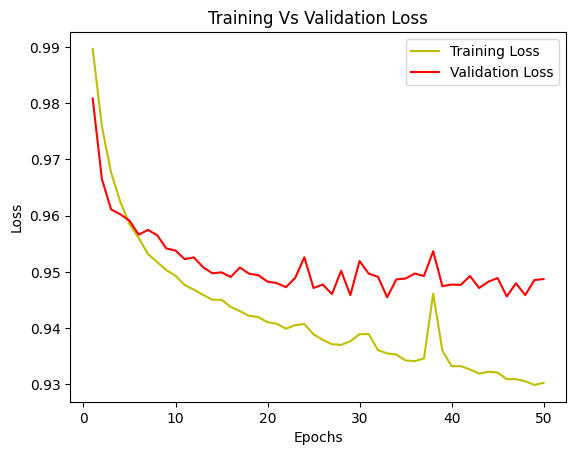

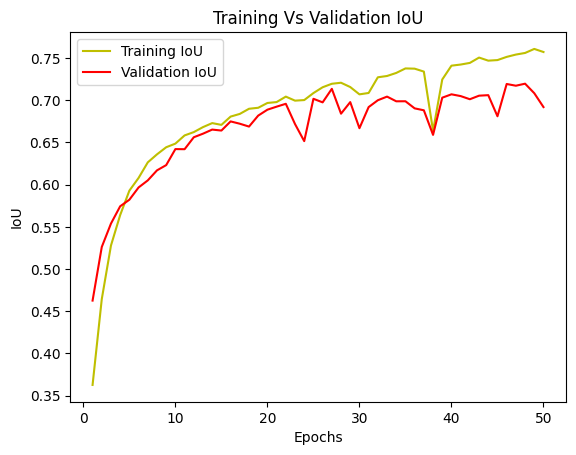

In [10]:
history_a = model_history

# Plot Training vs Validation Loss
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Training vs Validation IoU
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

## Evaluate Model on Test Data

C:\Users\RITESH KR. SHAW\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


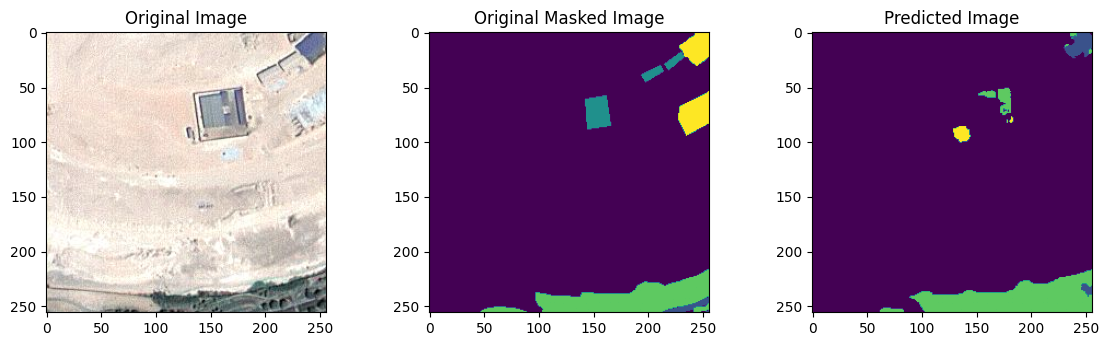

In [11]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

test_image_number = random.randint(0, len(X_test))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]

plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()

In [ ]:
model.save_weights('unet_weights.h5')